## 순환신경망 구현 및 학습

In [1]:
import tensorflow as tf

## 하이퍼 파라미터

In [2]:
EPOCHS = 10
NUM_WORDS = 10000

## 모델 정의

In [18]:
class MyModel(tf.keras.Model) : 
    def __init__(self) : 
        super(MyModel, self).__init__()
        self.emb = tf.keras.layers.Embedding(NUM_WORDS,16)
        self.rnn = tf.keras.layers.LSTM(128,dropout=0.2, recurrent_dropout=0.2)
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x, training=None, mask=None):
        x = self.emb(x)
        x = self.rnn(x)
        return self.dense(x)

In [4]:
@tf.function
def train_step(model, inputs, labels, loss_object,optimizer, train_loss, train_accuracy):
    with tf.GradientTape() as tape : 
        predictions = model(inputs, training=True)
        loss = loss_object(labels,predictions)
        
    gradients = tape.gradient(loss,model.trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels,predictions)
    
@tf.function
def test_step(model,inputs, labels, loss_object, test_loss, test_accuracy) : 
    predictions = model(inputs, training=False)
    
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)


## 데이터셋 준비


In [5]:
imdb = tf.keras.datasets.imdb
(x_train, y_train), (x_test,y_test) = imdb.load_data(num_words=NUM_WORDS)

In [9]:
print(x_train)

[[  30 5535   18 ...   19  178   32]
 [   9    6  371 ...   16  145   95]
 [   4   22   47 ...    7  129  113]
 ...
 [ 139  929 2901 ...    4 3586    2]
 [ 145    5  202 ...   12    9   23]
 [  21   60   27 ...  204  131    9]]


In [6]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                       value=0,
                                                       padding='pre',
                                                       maxlen=32)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=0,
                                                       padding='pre',
                                                       maxlen=32)

train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(32)

## 모델 생성

In [7]:
model = MyModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')



## 학습 루프 동작

In [8]:
for epoch in range(EPOCHS) : 
    
    for seqs, labels in train_ds : 
        train_step(model, seqs, labels, loss_object, optimizer, train_loss,train_accuracy)
        
    for seqs, test_labels in test_ds : 
        test_step(model, seqs, test_labels,loss_object,test_loss, test_accuracy)
        
    template = 'Epoch {} Loss: {}, Accuracy : {}, Test loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    

Epoch 1 Loss: 0.5229719281196594, Accuracy : 72.93199920654297, Test loss: 0.44374436140060425, Test Accuracy: 78.89999389648438
Epoch 2 Loss: 0.35815495252609253, Accuracy : 84.47999572753906, Test loss: 0.4748471975326538, Test Accuracy: 78.02400207519531
Epoch 3 Loss: 0.20977844297885895, Accuracy : 91.8239974975586, Test loss: 0.6019107103347778, Test Accuracy: 76.86000061035156
Epoch 4 Loss: 0.0881834402680397, Accuracy : 97.04000091552734, Test loss: 0.8148474097251892, Test Accuracy: 74.23200225830078
Epoch 5 Loss: 0.03751372545957565, Accuracy : 98.85600280761719, Test loss: 1.0285437107086182, Test Accuracy: 74.38399505615234
Epoch 6 Loss: 0.020614685490727425, Accuracy : 99.37999725341797, Test loss: 1.1488250494003296, Test Accuracy: 74.06800079345703
Epoch 7 Loss: 0.01727299764752388, Accuracy : 99.41200256347656, Test loss: 1.2435027360916138, Test Accuracy: 73.83599853515625
Epoch 8 Loss: 0.017817215994000435, Accuracy : 99.41600036621094, Test loss: 1.3100353479385376, T

In [16]:
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)

In [19]:
model = MyModel()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[earlystopper])

Train for 782 steps, validate for 782 steps
Epoch 1/10
782/782 [==============================] - 34s 43ms/step - loss: 0.5250 - accuracy: 0.7274 - val_loss: 0.4400 - val_accuracy: 0.7916
Epoch 2/10
782/782 [==============================] - 30s 39ms/step - loss: 0.3939 - accuracy: 0.8235 - val_loss: 0.4450 - val_accuracy: 0.7912
Epoch 3/10
782/782 [==============================] - 30s 38ms/step - loss: 0.3491 - accuracy: 0.8493 - val_loss: 0.5085 - val_accuracy: 0.7811
Epoch 4/10
782/782 [==============================] - 30s 38ms/step - loss: 0.3180 - accuracy: 0.8657 - val_loss: 0.4639 - val_accuracy: 0.7835
Epoch 5/10
782/782 [==============================] - 30s 38ms/step - loss: 0.2871 - accuracy: 0.8821 - val_loss: 0.5122 - val_accuracy: 0.7813
Epoch 6/10
782/782 [==============================] - 30s 38ms/step - loss: 0.2549 - accuracy: 0.8978 - val_loss: 0.5429 - val_accuracy: 0.7777
Epoch 7/10
782/782 [==============================] - 30s 39ms/step - loss: 0.2164 - accurac

In [23]:
score, acc = model.evaluate(x_test, y_test,batch_size=32)

25000/25000 [==============================] - 5s 202us/sample - loss: 0.7136 - accuracy: 0.7622


In [24]:
print("Test Score: ", score)
print("Test Accuracy: ", acc)

Test Score:  0.713602087612152
Test Accuracy:  0.76216


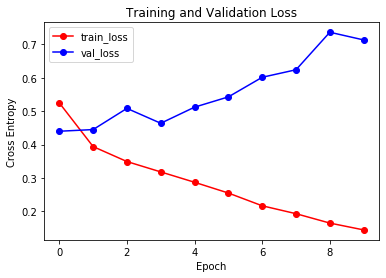

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, 'ro-', label="train_loss")
plt.plot(val_loss, 'bo-', label="val_loss")
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.title('Training and Validation Loss')
plt.show()

In [25]:
# Model weight matrix 저장.
model.save_weights("nsmc_keras_simplelstm")